# Compare SMOS/SMAP and PIOMAS SIT

### Module import

In [1]:
import netCDF4
import numpy as np
import xarray as xr
import pyproj
import cartopy.crs as ccrs
import pylab as plt
import pyhdf
from pyhdf.SD import SD, SDC
from pyresample import geometry,kd_tree,image
from osgeo import gdal

In [2]:
def regrid_swath_to_swath(data,lon_in,lat_in,lon_out,lat_out,radius_of_influence = 10000,eps = 0.5,fill_value = np.nan):
    """Regrid array using nearest neighbour. Change radius_of_influence depending on dataset. Input:
        - data: data to be gridded to the other grid (input dataset)
        - lon_in/lat_in: coordinates of input dataset
        - lon_out/lat_out: coordinates of target grid
        - radius_of_influence: If no pixel is found within this distance (in meters) on the input dataset, the pixel in the output dataset will be set to nan (or another fill_value to be specified in the function below)
        - eps: measure of uncertainty, larger eps mean shorter execution time
        - fill_value: Pixel will be set to this value if no pixel is found within radius_of_influence (in meters)"""

    swath_def_in = geometry.SwathDefinition(lons=lon_in, lats=lat_in)
    swath_def_out = geometry.SwathDefinition(lons=lon_out, lats=lat_out)
    data_out = kd_tree.resample_nearest(swath_def_in, data, swath_def_out, radius_of_influence=radius_of_influence, epsilon=eps, fill_value = fill_value)
    return data_out


### Load and prepare data

##### CS-SMOS SIT and geolocation

In [3]:
f_pmw = xr.open_dataset("/Users/vludwig/05_SINXS/02_DATA/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20230101_20230107_r_v205_01_l4sit.nc") # pmw = passive microwave


In [52]:
sit_cs_smos = np.array(f_pmw["analysis_sea_ice_thickness"][0,:,:])
sit_cs = np.array(f_pmw["cryosat_sea_ice_thickness"][0,:,:])
sit_smos = np.array(f_pmw["smos_sea_ice_thickness"][0,:,:])
lon_cs = f_pmw["lon"][:,:]
lat_cs = f_pmw["lat"][:,:]

In [5]:
hdf = SD("/Users/vludwig/05_SINXS/02_DATA/LongitudeLatitudeGrid-n12500-Arctic.hdf", SDC.READ)
lat_nsidc = hdf.select('Latitudes')[:,:]
#lat_nsidc = lat_tmp[:,:]
lon_nsidc = hdf.select('Longitudes')[:,:]
#lon_nsidc = lon_tmp[:,:]

##### PIOMAS

In [6]:
#f_piomas = netCDF4.Dataset("/Users/vludwig/Desktop/PIOMAS/hiday.H2018",mode = "r")
#sit_piomas = np.reshape(f_piomas.variables["hiday"],(1,365,120,360))[0,0,:,:]
#sit_piomas[sit_piomas==0] = np.nan
#lon_piomas_1d = np.array(f_piomas.variables["x"])
#lat_piomas_1d = np.array(f_piomas.variables["y"])
#lon_piomas =np.reshape(lon_piomas_1d,(120,360))
#lat_piomas =np.reshape(lat_piomas_1d,(120,360))

In [7]:
f_piomas = xr.open_dataset("/Users/vludwig/Desktop/PIOMAS/hiday.H2023")
sit_piomas_all = np.array(f_piomas["hiday"])

In [138]:
sit_piomas = np.nanmean(np.reshape(sit_piomas_all,(1,120,120,360))[0,0:6,:,:],axis = 0)
sit_piomas[sit_piomas<1e-3] = np.nan
lon_piomas_1d = np.array(f_piomas.variables["x"])
lat_piomas_1d = np.array(f_piomas.variables["y"])
lon_piomas =np.reshape(lon_piomas_1d,(120,360))
lat_piomas =np.reshape(lat_piomas_1d,(120,360))

##### Regrid PIOMAS

In [9]:
sit_piomas_nsidc = regrid_swath_to_swath(sit_piomas,lon_piomas,lat_piomas,lon_cs,lat_cs,radius_of_influence=25000)

### Plotting

In [10]:
plotdir = "/Users/vludwig/05_SINXS/03_PLOTS/"

In [95]:
vmin_all = np.min([np.nanmin(sit_piomas),np.nanmin(sit_cs_smos)])
vmax_all = np.max([np.nanmax(sit_piomas),np.nanmax(sit_cs_smos)])
vmin_all = 0
vmax_all = 3

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/1479630471.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


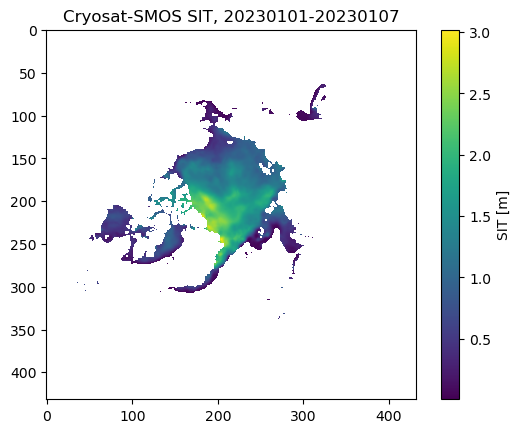

In [74]:
# Cryosat-SMOS SIT, native grid
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Cryosat-SMOS SIT, 20230101-20230107")
im = ax.imshow(sit_cs_smos)
cb = plt.colorbar(im)
cb.set_label("SIT [m]")
fig.savefig(plotdir+"sit_cs_smos_native_20230101.pdf",bbox_inches = "tight")
fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/346425555.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


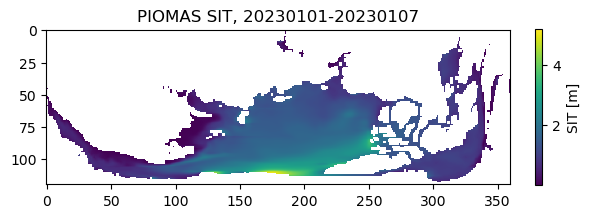

In [140]:
# PIOMAS SIT, native grid
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("PIOMAS SIT, 20230101-20230107")
im = ax.imshow(sit_piomas)
cb = plt.colorbar(im,fraction=0.047*(sit_piomas.shape[0]/sit_piomas.shape[1]))
cb.set_label("SIT [m]")
fig.savefig(plotdir+"sit_piomas_native_20230101.pdf",bbox_inches = "tight")
fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/3001041624.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


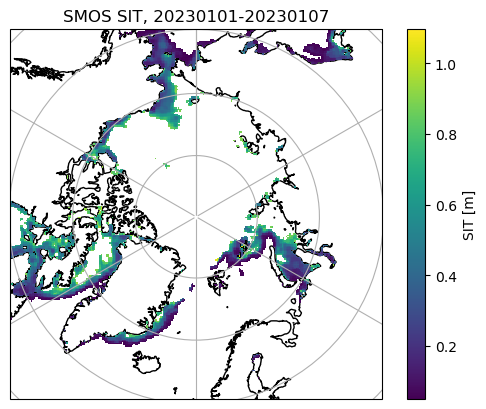

In [55]:
# SMOS SIT
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60,90], ccrs.PlateCarree())

ax.coastlines();
ax.gridlines();
ax.set_title("SMOS SIT, 20230101-20230107")
im = ax.pcolormesh(lon_cs,lat_cs,sit_smos,zorder=2,transform = ccrs.PlateCarree())
cb = plt.colorbar(im)
cb.set_label("SIT [m]")
fig.savefig(plotdir+"sit_smos_20230101.png",bbox_inches = "tight",dpi = 200)
fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/2683445798.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


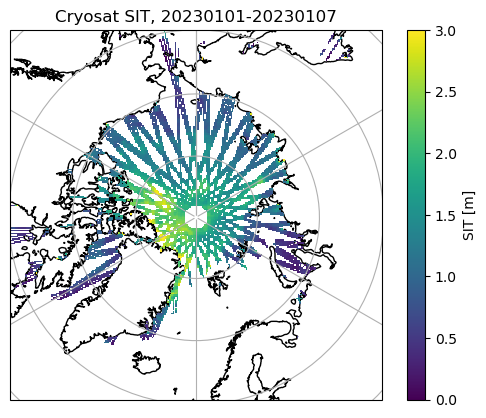

In [54]:
# CS SIT
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60,90], ccrs.PlateCarree())

ax.coastlines();
ax.gridlines();
ax.set_title("Cryosat SIT, 20230101-20230107")
im = ax.pcolormesh(lon_cs,lat_cs,sit_cs,zorder=2,transform = ccrs.PlateCarree(),vmin = 0, vmax = 3)
cb = plt.colorbar(im)
cb.set_label("SIT [m]")
fig.savefig(plotdir+"sit_cs_20230101.png",bbox_inches = "tight",dpi = 200)
fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/2616229766.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


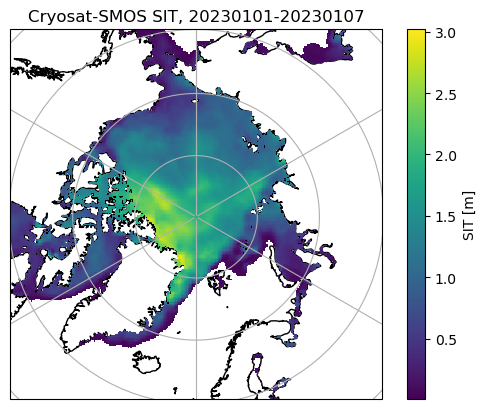

In [11]:
# CS-SMOS SIT
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60,90], ccrs.PlateCarree())

ax.coastlines();
ax.gridlines();
ax.set_title("Cryosat-SMOS SIT, 20230101-20230107")
im = ax.pcolormesh(lon_cs,lat_cs,sit_cs,zorder=2,transform = ccrs.PlateCarree())
cb = plt.colorbar(im)
cb.set_label("SIT [m]")
fig.savefig(plotdir+"sit_cs_smos_20230101.png",bbox_inches = "tight",dpi = 200)
fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/2210875303.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


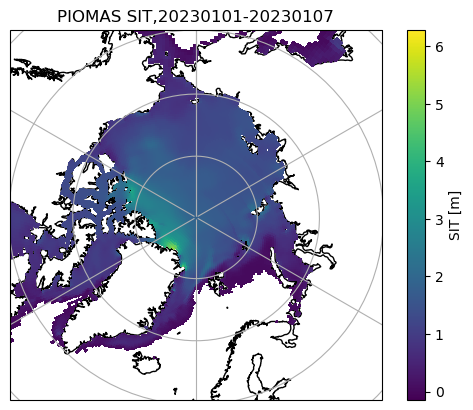

In [126]:
# PIOMAS original grid
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60,90], ccrs.PlateCarree())
ax.coastlines();
ax.gridlines();
ax.set_title("PIOMAS SIT,20230101-20230107")
im = ax.pcolormesh(lon_piomas,lat_piomas,sit_piomas,zorder=2,transform = ccrs.PlateCarree(),vmin = np.nanmin(sit_cs), vmax = np.nanmax(sit_cs))
cb = plt.colorbar(im)
cb.set_label("SIT [m]")
fig.savefig(plotdir+"sit_piomas_20230101.png",bbox_inches = "tight",dpi = 200)
fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/3137270301.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


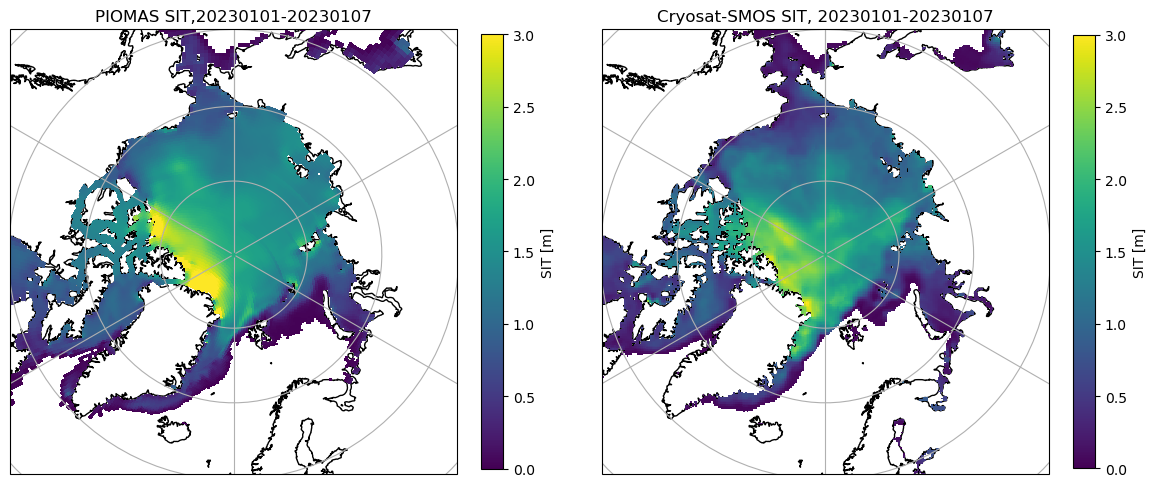

In [141]:
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(14,8))
ax1 = axs[0]
#ax1 = plt.axes(projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 60,90], ccrs.PlateCarree())
ax1.coastlines();
ax1.gridlines();
ax1.set_title("PIOMAS SIT,20230101-20230107")
im = ax1.pcolormesh(lon_piomas,lat_piomas,sit_piomas,zorder=2,transform = ccrs.PlateCarree(),vmin = vmin_all, vmax = vmax_all)
cb = plt.colorbar(im,fraction=0.044*(lon_cs.shape[0]/lon_cs.shape[1]))
cb.set_label("SIT [m]")

ax2 = axs[1]
ax2.set_extent([-180, 180, 60,90], ccrs.PlateCarree())
ax2.coastlines();
ax2.gridlines();
ax2.set_title("Cryosat-SMOS SIT, 20230101-20230107")
im = ax2.pcolormesh(lon_cs,lat_cs,sit_cs_smos,zorder=2,transform = ccrs.PlateCarree(),vmin = vmin_all, vmax = vmax_all)
cb = plt.colorbar(im,fraction=0.044*(lon_cs.shape[0]/lon_cs.shape[1]))
cb.set_label("SIT [m]")
fig.savefig(plotdir+"sit_cs_smos_piomas_20230101.png",bbox_inches = "tight",dpi = 200)
fig.show()

### Histograms

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/1798132921.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


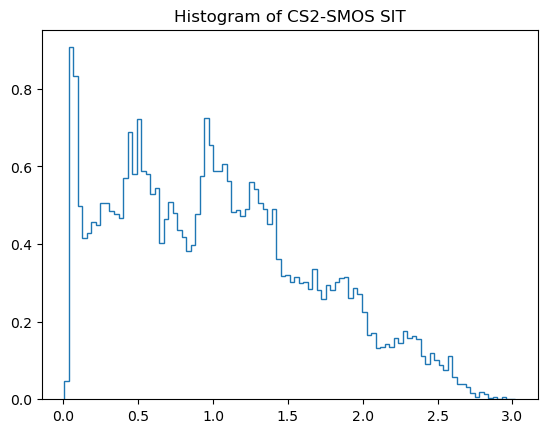

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Histogram of CS2-SMOS SIT")
ax.hist(sit_cs.flatten(),bins = 100,histtype = "step",density = True)
fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/1698780563.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


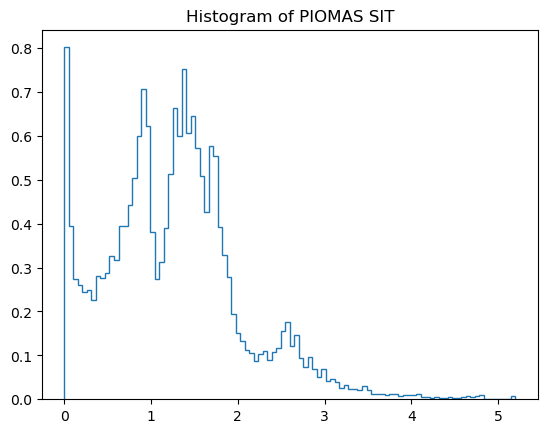

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Histogram of PIOMAS SIT")
ax.hist(sit_piomas.flatten(),bins = 100,histtype = "step",density = True)
fig.show()

### Boxplots

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/1688378760.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


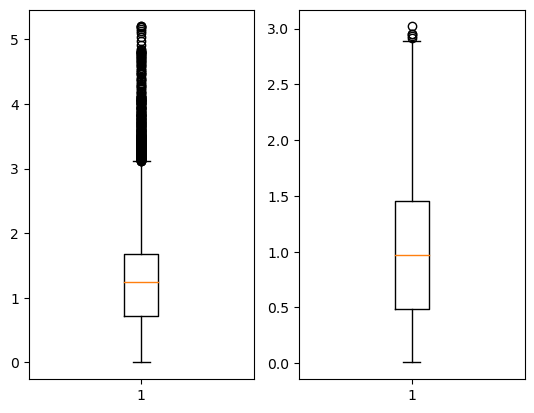

In [15]:
fig = plt.figure()
ax = fig.add_subplot(121)
plt.boxplot(sit_piomas[~np.isnan(sit_piomas)])
ax = fig.add_subplot(122)
plt.boxplot(sit_cs[~np.isnan(sit_cs)])
fig.show()

In [16]:
dict4boxplot = {"Cryosat-SMOS":sit_cs[~np.isnan(sit_cs)],"PIOMAS":sit_piomas[~np.isnan(sit_piomas)]}

In [130]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][0:2]
colordict = {"PIOMAS":colors[0],"Cryosat-SMOS":colors[1]}

2.616127166750933e-09

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_53904/2278451234.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


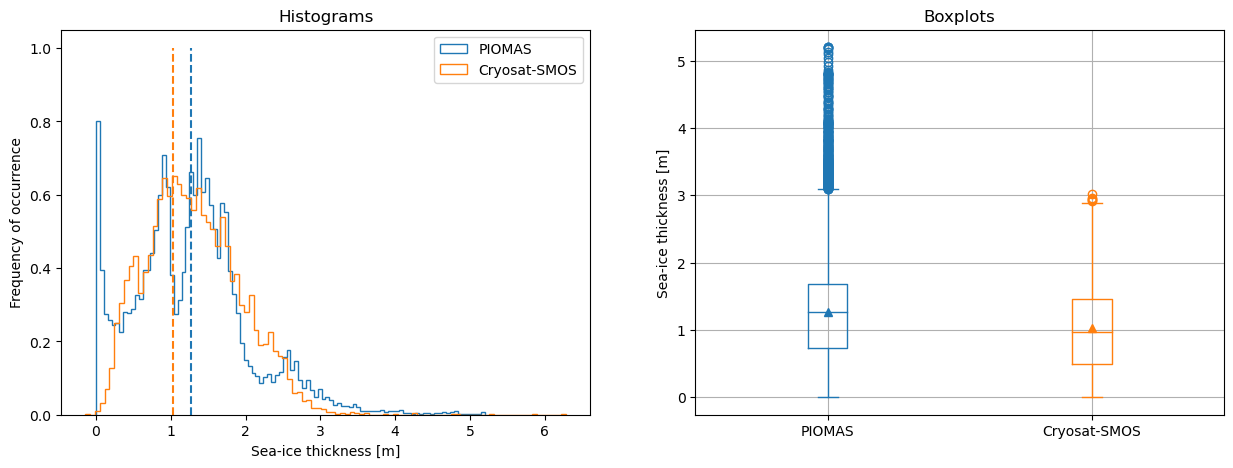

In [136]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax1.set_title("Histograms")
ax1.hist(sit_piomas.flatten(),bins = 100,histtype = "step",density = True,label = "PIOMAS",color = colordict["PIOMAS"])
ax1.vlines(np.nanmean(sit_piomas),color = colors[0],linestyle = "dashed",ymin = 0, ymax = 1)
ax1.vlines(np.nanmean(sit_cs_smos),color = colors[1],linestyle = "dashed",ymin = 0, ymax = 1)
#ax1.text(x = 4.5, y = .9, s = f"Mean: {np.round(np.nanmean(sit_piomas),2)}",color = colors[0])
#ax1.text(x = 4.5, y = .85, s = f"Mean: {np.round(np.nanmean(sit_cs_smos),2)}",color = colors[1])
ax1.hist(sit_cs.flatten(),bins = 100,histtype = "step",density = True, label = "Cryosat-SMOS",color = colordict["Cryosat-SMOS"])
ax1.set_ylabel("Frequency of occurrence")
ax1.set_xlabel("Sea-ice thickness [m]")
ax1.legend(loc = "upper right")
#ax1.grid()
ax2 = fig.add_subplot(122)
ax2.set_title("Boxplots")
ax2.set_ylabel("Sea-ice thickness [m]")
ax2.grid()
bp = plt.boxplot([sit_piomas[~np.isnan(sit_piomas)],sit_cs_smos[~np.isnan(sit_cs_smos)]],showmeans=True,labels = ["PIOMAS","Cryosat-SMOS"])

for flier,mean,median,patch, color in zip(bp["fliers"],bp['means'],bp['medians'],bp['boxes'], colors):
    patch.set_color(color)
    mean.set_markerfacecolor(color)
    mean.set_markeredgecolor(color)
    median.set_color(color)
    flier.set_markeredgecolor(color)
    
for cap,whisker, color in zip(bp["caps"],bp['whiskers'], [colors[0],colors[0],colors[1],colors[1]]):
    whisker.set_color(color)
    cap.set_color(color)
    #flier.set_color(color)
fig.savefig(plotdir+"sit_boxplots_20230101.pdf",bbox_inches = "tight")
fig.show()

### Spatial resolution

In [31]:
x = f_pmw["xc"]
y = f_pmw["yc"]
x_2d,y_2d =np.meshgrid(x,y)

In [29]:
(x[-1]-x[0])/len(x)

<xarray.DataArray 'xc' ()>
array(24.94212963)

In [30]:
(y[0]-y[-1])/len(y)

<xarray.DataArray 'yc' ()>
array(24.94212963)

In [45]:
xdist,ydist = [],[]
for i in range(x_2d.shape[0]):
    xdist.append(x_2d[i,-1]-x_2d[i,0])
    ydist.append(y_2d[-1,i]-y_2d[0,i])

In [47]:
np.unique(xdist)/x_2d.shape[0],np.unique(ydist)/x_2d.shape[0]


(array([24.94213], dtype=float32), array([-24.94213], dtype=float32))

##### Regridded, ongoing

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_32747/267768269.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


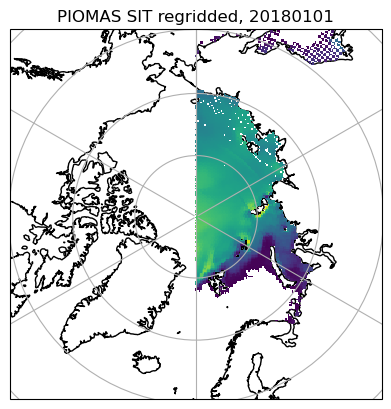

In [34]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60,90], ccrs.PlateCarree())
# Plot the data as usual
#z.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, cmap='terrain') 
# Add details to the plot:
ax.coastlines();
ax.gridlines();
ax.set_title("PIOMAS SIT regridded, 20180101")
ax.pcolormesh(lon_cs,lat_cs,sit_piomas_nsidc,zorder=2,transform = ccrs.PlateCarree())
cb = plt.colorbar(im)
cb.set_label("SIT [cm]")
fig.show()

##### Playground

In [22]:
f_sic = xr.open_dataset("/Users/vludwig/05_SINXS/02_DATA/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_20230508.nc")
f_lonlat = xr.open_dataset("/Users/vludwig/05_SINXS/02_DATA/coordinates_npstere_1km_arctic.nc")

In [26]:
sic = f_sic["sic_merged"]
lon = f_lonlat["lon"]
lat = f_lonlat["lat"]